In [7]:
import os
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%pip install autoviz 
from autoviz.AutoViz_Class import AutoViz_Class
import warnings
warnings.filterwarnings("ignore")
%pip install pandas-profiling
import pandas_profiling #Data Analysis: for profiling the data
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [8]:
data_dir= os.path.join(os.getcwd(),"data","IoTData.xlsx")
Preprocessed_data = pd.read_excel(data_dir)
Preprocessed_data.head()

,DATETIME,TEMP_AIR,UMIDADE_REL,KW,KW2
0,2019-09-15 00:00:00,18.7,80.0,690.48,69.048
1,2019-09-15 01:00:00,18.2,83.0,685.44,68.544
2,2019-09-15 02:00:00,18.2,83.0,656.88,65.688
3,2019-09-15 03:00:00,18.2,83.0,655.20,65.520
4,2019-09-15 04:00:00,18.3,82.0,660.24,66.024


In [9]:
Preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8336 entries, 0 to 8335
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATETIME     8336 non-null   datetime64[ns]
 1   TEMP_AIR     8335 non-null   float64       
 2   UMIDADE_REL  8335 non-null   float64       
 3   KW           8336 non-null   float64       
 4   KW2          8336 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 325.8 KB


In [10]:
Preprocessed_data.isna().sum()

DATETIME       0
TEMP_AIR       1
UMIDADE_REL    1
KW             0
KW2            0
dtype: int64

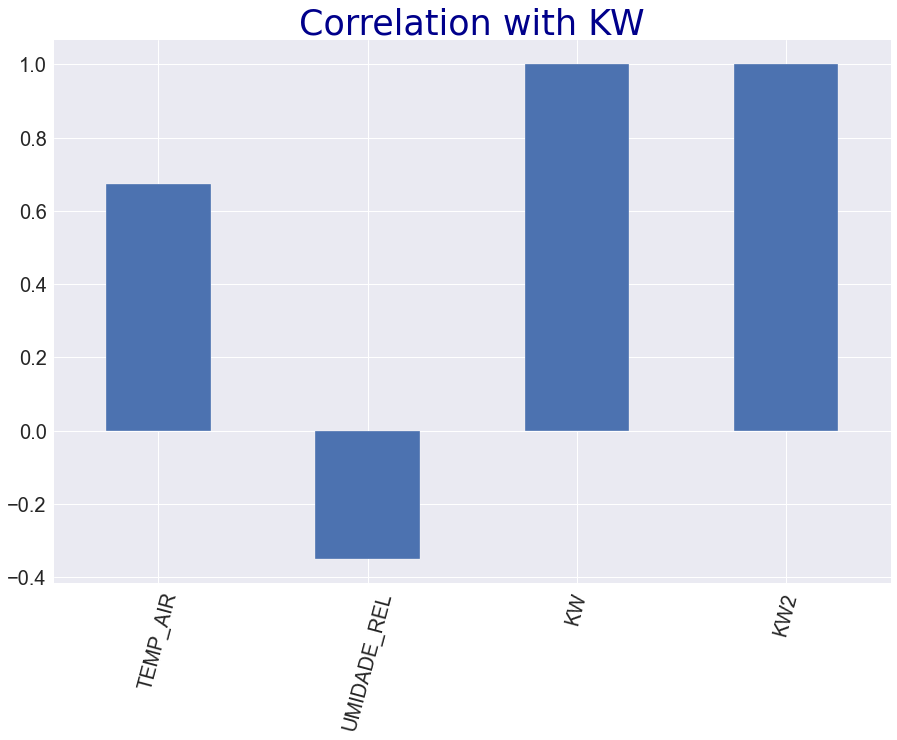

In [11]:
plt.title("Correlation with KW",fontsize=35,color='DarkBlue',fontname='DejaVu Sans')
Preprocessed_data.corrwith(Preprocessed_data.KW).plot.bar(figsize=(15,10),
                                            fontsize=20,
                                            rot=75,grid=True)
plt.show()

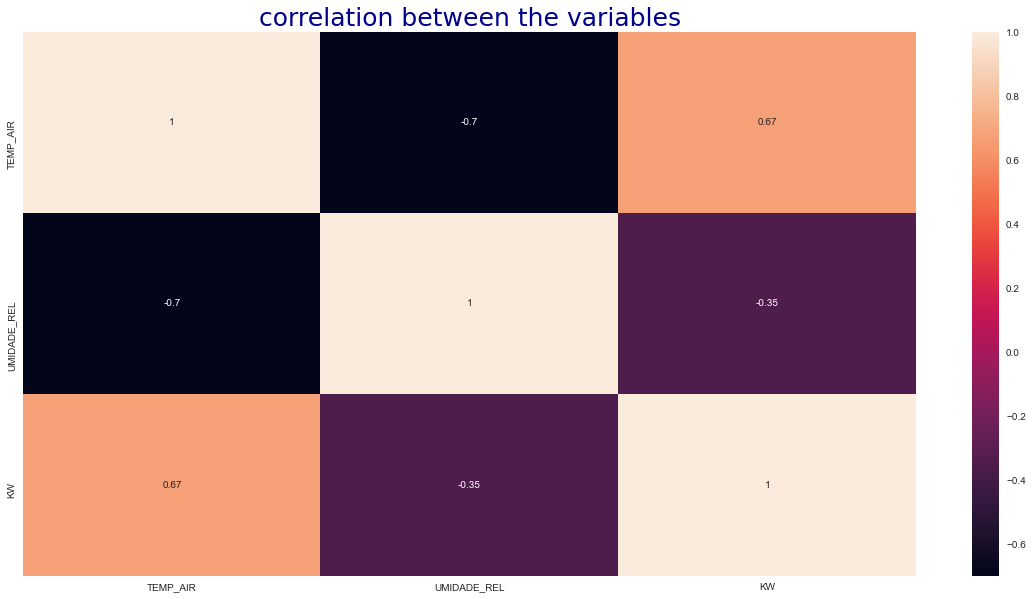

In [12]:
Preprocessed_data=Preprocessed_data.drop(columns=["KW2"])
plt.figure(figsize=(20,10)) 
sns.heatmap(Preprocessed_data.corr(),annot=True)
plt.title("correlation between the variables",fontsize=25,color="DarkBlue",fontname="DejaVu Sans")
plt.show()

In [13]:
from sklearn.impute import SimpleImputer
Preprocessed_data['TEMP_AIR'].fillna(Preprocessed_data['TEMP_AIR'].mean(), inplace=True)
Preprocessed_data['UMIDADE_REL'].fillna(Preprocessed_data['UMIDADE_REL'].mean(),inplace=True)

In [14]:
Preprocessed_data.isna().sum()

DATETIME       0
TEMP_AIR       0
UMIDADE_REL    0
KW             0
dtype: int64

In [15]:
Preprocessed_data=Preprocessed_data.drop(columns=['TEMP_AIR', 'UMIDADE_REL'])

In [16]:
Preprocessed_data.head()

,DATETIME,KW
0,2019-09-15 00:00:00,690.48
1,2019-09-15 01:00:00,685.44
2,2019-09-15 02:00:00,656.88
3,2019-09-15 03:00:00,655.20
4,2019-09-15 04:00:00,660.24


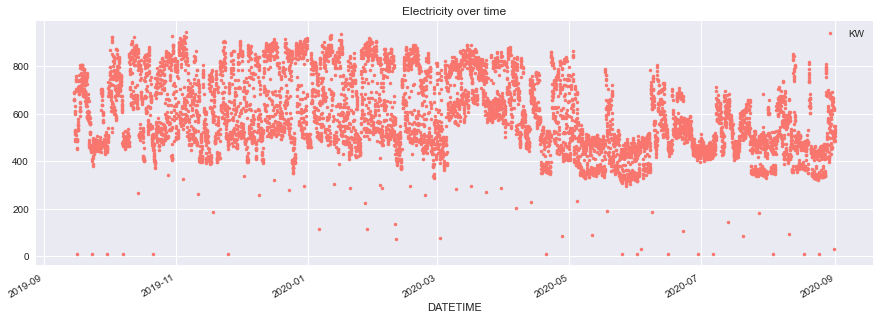

In [17]:
Preprocessed_data.set_index("DATETIME", inplace = True)
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
Preprocessed_data.plot(style='.', figsize=(15,5), color=color_pal[0], title='Electricity over time')
plt.show()

In [18]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

def ts_plots(df):
    sns_plot = sns.pairplot(df.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'month','weekofyear'],
             y_vars='KW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
    plt.suptitle('Electricity Use by Hour, Day of Week, Year and Week of Year')
    plt.show()
    

In [19]:
X, y = create_features(Preprocessed_data, label='KW')
features_and_target = pd.concat([X, y], axis=1)
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,KW
DATETIME,,,,,,,,,
2019-09-15 00:00:00,0,6,3,9,2019,258,15,37,690.48
2019-09-15 01:00:00,1,6,3,9,2019,258,15,37,685.44
2019-09-15 02:00:00,2,6,3,9,2019,258,15,37,656.88
2019-09-15 03:00:00,3,6,3,9,2019,258,15,37,655.20
2019-09-15 04:00:00,4,6,3,9,2019,258,15,37,660.24


Plotting the Features to see trend

#Power demand has strong hrly, daily and seasonal properties.
#Month also seems to show differences in peaks

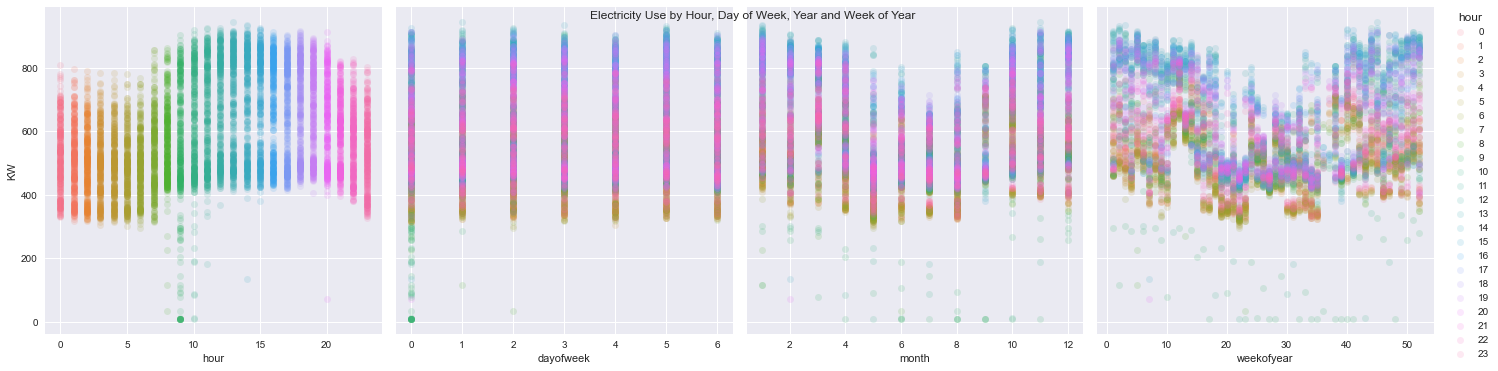

In [20]:
ts_plots(features_and_target)

Train/Test Split

In [21]:
Preprocessed_data.head()

,KW
DATETIME,
2019-09-15 00:00:00,690.48
2019-09-15 01:00:00,685.44
2019-09-15 02:00:00,656.88
2019-09-15 03:00:00,655.20
2019-09-15 04:00:00,660.24


In [22]:
Preprocessed_data.tail()

,KW
DATETIME,
2020-08-31 16:00:00,525.840027
2020-08-31 17:00:00,504.000000
2020-08-31 18:00:00,535.919983
2020-08-31 19:00:00,517.440003
2020-08-31 20:00:00,485.519990


In [23]:
Preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8336 entries, 2019-09-15 00:00:00 to 2020-08-31 20:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KW      8336 non-null   float64
dtypes: float64(1)
memory usage: 130.2 KB


In [24]:
split_date = '2020-06-30'
dataset_train = Preprocessed_data.loc[Preprocessed_data.index <= split_date].copy()
dataset_test = Preprocessed_data.loc[Preprocessed_data.index > split_date].copy()

In [25]:
dataset_test.head()

,KW
DATETIME,
2020-06-30 01:00:00,425.040009
2020-06-30 02:00:00,414.959992
2020-06-30 03:00:00,423.359986
2020-06-30 04:00:00,414.959992
2020-06-30 05:00:00,396.480011


In [26]:
dataset_train.tail()

,KW
DATETIME,
2020-06-29 20:00:00,463.679993
2020-06-29 21:00:00,456.959992
2020-06-29 22:00:00,458.640015
2020-06-29 23:00:00,445.200013
2020-06-30 00:00:00,441.839997


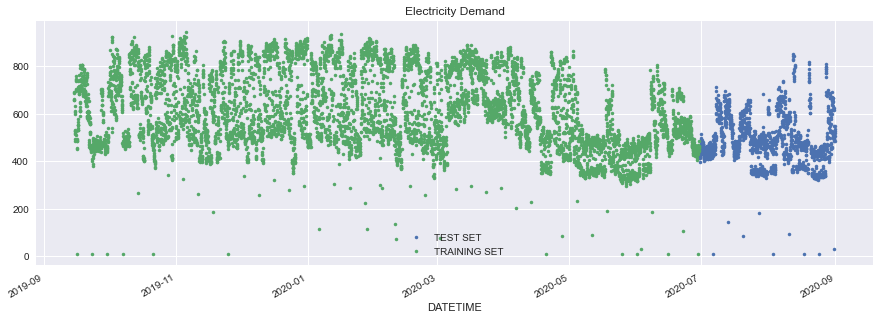

In [27]:
# Plot train and test so you can see where we have split
dataset_test \
    .rename(columns={'KW': 'TEST SET'}) \
    .join(dataset_train.rename(columns={'KW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Electricity Demand', style='.')
plt.show()

# Simple Prophet Model

1. Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

In [42]:
# Format data for prophet model using ds and y
df=dataset_train.reset_index() \
    .rename(columns={'DATETIME':'ds',
                     'KW':'y'})

In [44]:
df.head()

,ds,y
0,2019-09-15 00:00:00,690.48
1,2019-09-15 01:00:00,685.44
2,2019-09-15 02:00:00,656.88
3,2019-09-15 03:00:00,655.20
4,2019-09-15 04:00:00,660.24


In [ ]:
# Setup and train model and fit
model = Prophet()
model.fit(dataset_train.reset_index() \
              .rename(columns={'DATETIME':'ds',
                               'KW':'y'}), algorithm='Newton')


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


# ARIMA

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6
rcParams['axes.grid']=True
rcParams['font.size']=14

In [60]:
Preprocessed_data.head()

,KW
DATETIME,
2019-09-15 00:00:00,690.48
2019-09-15 01:00:00,685.44
2019-09-15 02:00:00,656.88
2019-09-15 03:00:00,655.20
2019-09-15 04:00:00,660.24


In [30]:
Preprocessed_data.index

DatetimeIndex(['2019-09-15 00:00:00', '2019-09-15 01:00:00',
               '2019-09-15 02:00:00', '2019-09-15 03:00:00',
               '2019-09-15 04:00:00', '2019-09-15 05:00:00',
               '2019-09-15 06:00:00', '2019-09-15 07:00:00',
               '2019-09-15 08:00:00', '2019-09-15 09:00:00',
               ...
               '2020-08-31 11:00:00', '2020-08-31 12:00:00',
               '2020-08-31 13:00:00', '2020-08-31 14:00:00',
               '2020-08-31 15:00:00', '2020-08-31 16:00:00',
               '2020-08-31 17:00:00', '2020-08-31 18:00:00',
               '2020-08-31 19:00:00', '2020-08-31 20:00:00'],
              dtype='datetime64[ns]', name='DATETIME', length=8336, freq=None)

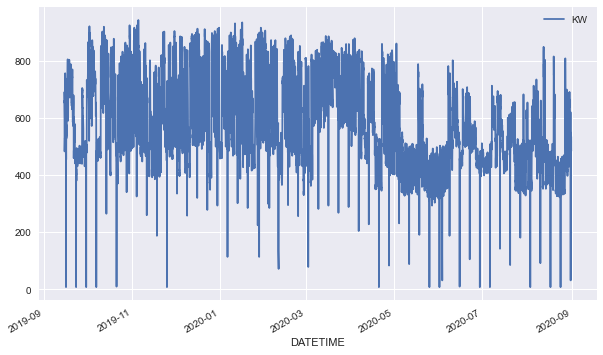

In [31]:
Preprocessed_data.plot()

In [61]:
#Determine Rolling Statistics
dt_mean = Preprocessed_data.rolling(window=24).mean()
dt_std = Preprocessed_data.rolling(window=24).std()
print(dt_mean,dt_std)

                             KW
DATETIME                       
2019-09-15 00:00:00         NaN
2019-09-15 01:00:00         NaN
2019-09-15 02:00:00         NaN
2019-09-15 03:00:00         NaN
2019-09-15 04:00:00         NaN
...                         ...
2020-08-31 16:00:00  531.579999
2020-08-31 17:00:00  525.419998
2020-08-31 18:00:00  520.029996
2020-08-31 19:00:00  514.569997
2020-08-31 20:00:00  508.479997

[8336 rows x 1 columns]                              KW
DATETIME                       
2019-09-15 00:00:00         NaN
2019-09-15 01:00:00         NaN
2019-09-15 02:00:00         NaN
2019-09-15 03:00:00         NaN
2019-09-15 04:00:00         NaN
...                         ...
2020-08-31 16:00:00  122.875332
2020-08-31 17:00:00  120.262299
2020-08-31 18:00:00  116.563407
2020-08-31 19:00:00  113.308635
2020-08-31 20:00:00  110.636992

[8336 rows x 1 columns]


# Checking stationarity with rolling mean and standard deviation

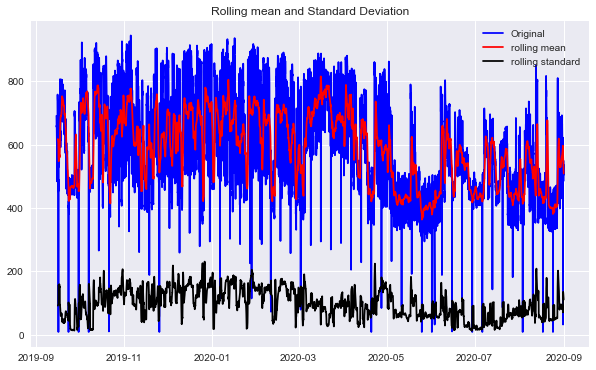

In [62]:
#Ploting rolling statistics:
plt.plot(Preprocessed_data,color="blue",label="Original")
plt.plot(dt_mean, color="red",label="rolling mean")
plt.plot(dt_std, color="black",label="rolling standard")
plt.legend(loc='best')
plt.title("Rolling mean and Standard Deviation")
plt.show()

# Checking Stationarity with Augmented Dickey Fuller Statistical Test

In [63]:
#Perform Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
print("Results of Dicky Fuller Test")
dftest = adfuller(Preprocessed_data['KW'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistics','p-value','#Lags Used','No of Observations used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)


Results of Dicky Fuller Test
Test Statistics           -7.727058e+00
p-value                    1.151531e-11
#Lags Used                 3.200000e+01
No of Observations used    8.303000e+03
Critical Value (1%)       -3.431138e+00
Critical Value (5%)       -2.861888e+00
Critical Value (10%)      -2.566955e+00
dtype: float64


# Wrapping visual and statistical tools in single function

In [64]:
def test_stationary(timeseries):
    #Determining Rolling statistics:
    movingaverage = timeseries.rolling(window=24).mean()
    movingstd = timeseries.rolling(window=24).std()
    
    #plot rolling statistics:
    plt.plot(timeseries,color="blue",label="Original")
    plt.plot(movingaverage,color="red",label="Rolling Mean")
    plt.plot(movingstd,color="black",label="Rolling STD")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show()
    
    #Perform Dicky- Fuller Test:
    from statsmodels.tsa.stattools import adfuller
    print("Results of Dickey Fuller Test:")
    dftest = adfuller(timeseries["KW"],autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistics','p-value','#Lags Used','No of Observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

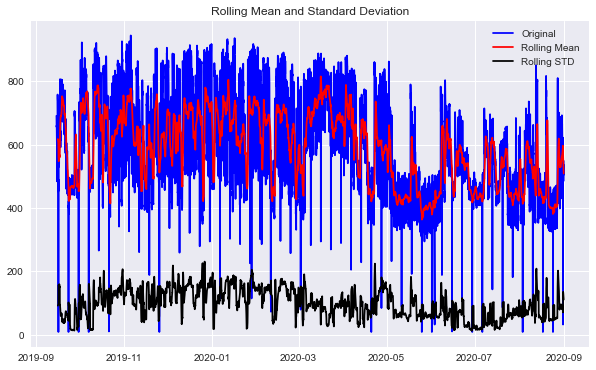

Results of Dickey Fuller Test:
Test Statistics           -7.727058e+00
p-value                    1.151531e-11
#Lags Used                 3.200000e+01
No of Observations used    8.303000e+03
Critical Value (1%)       -3.431138e+00
Critical Value (5%)       -2.861888e+00
Critical Value (10%)      -2.566955e+00
dtype: float64


In [65]:
test_stationary(Preprocessed_data)

# Converting Non-Stationary data to Stationary Dataset

1. Log
2. Subtracting simple rolling averages
3. Subtracting exponential rolling averages
4. Subtracting previous value with shift() -----> Most Popular one
5. Seasonal decomposition


1. Log 

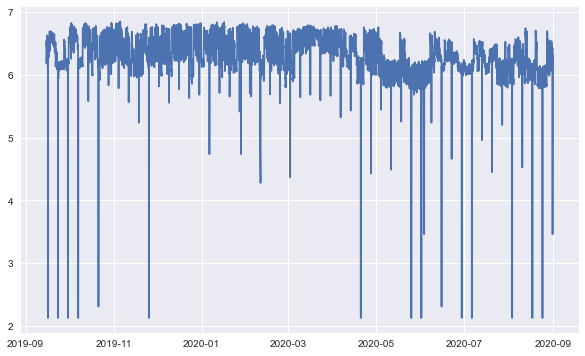

In [68]:
#Estimating Trend
Preprocessed_data_logscale = np.log(Preprocessed_data)
plt.plot(Preprocessed_data_logscale)
plt.show()

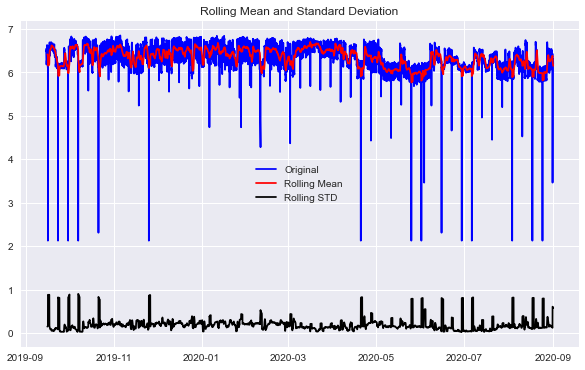

Results of Dickey Fuller Test:
Test Statistics           -7.831228e+00
p-value                    6.285203e-12
#Lags Used                 3.600000e+01
No of Observations used    8.299000e+03
Critical Value (1%)       -3.431138e+00
Critical Value (5%)       -2.861888e+00
Critical Value (10%)      -2.566955e+00
dtype: float64


In [69]:
test_stationary(Preprocessed_data_logscale)

2. Differencing Simple moving average

In [70]:
movingaverage = Preprocessed_data_logscale.rolling(window=720).mean()
datalogscaleminusmovingaverage = Preprocessed_data_logscale - movingaverage
datalogscaleminusmovingaverage.head()

,KW
DATETIME,
2019-09-15 00:00:00,NaN
2019-09-15 01:00:00,NaN
2019-09-15 02:00:00,NaN
2019-09-15 03:00:00,NaN
2019-09-15 04:00:00,NaN


In [71]:
#removing non values
datalogscaleminusmovingaverage.dropna(inplace=True)
datalogscaleminusmovingaverage.head()

,KW
DATETIME,
2019-10-15 07:00:00,-0.161711
2019-10-15 08:00:00,-0.125191
2019-10-15 09:00:00,-0.086883
2019-10-15 10:00:00,-0.062106
2019-10-15 11:00:00,0.312299


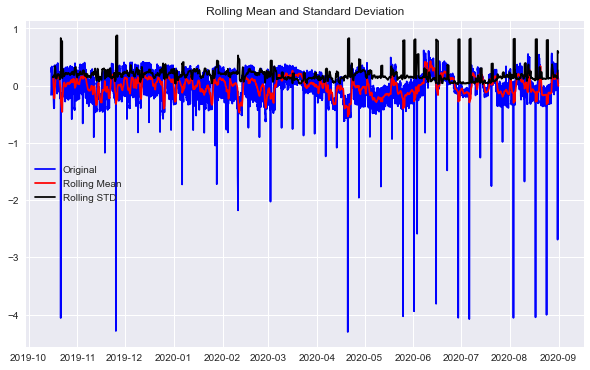

Results of Dickey Fuller Test:
Test Statistics           -9.844130e+00
p-value                    4.668383e-17
#Lags Used                 3.600000e+01
No of Observations used    7.580000e+03
Critical Value (1%)       -3.431213e+00
Critical Value (5%)       -2.861921e+00
Critical Value (10%)      -2.566973e+00
dtype: float64


In [72]:
test_stationary(datalogscaleminusmovingaverage)

3. Differencing exponential moving average

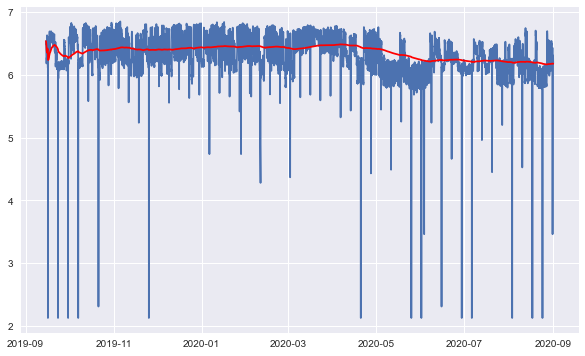

In [73]:
exponentialdecayweightedaverage = Preprocessed_data_logscale.ewm(halflife=720,min_periods=0,adjust=True).mean()
plt.plot(Preprocessed_data_logscale)
plt.plot(exponentialdecayweightedaverage,color="red")
plt.show()

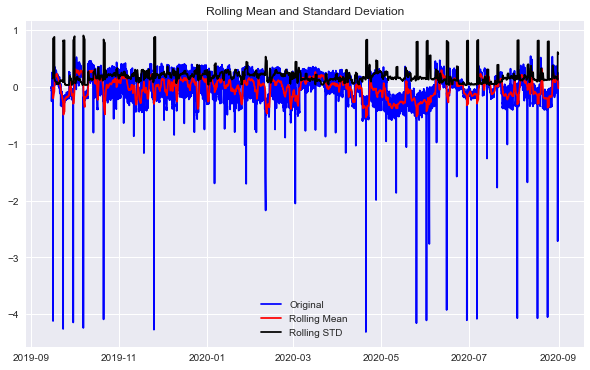

Results of Dickey Fuller Test:
Test Statistics           -9.889699e+00
p-value                    3.585167e-17
#Lags Used                 3.400000e+01
No of Observations used    8.301000e+03
Critical Value (1%)       -3.431138e+00
Critical Value (5%)       -2.861888e+00
Critical Value (10%)      -2.566955e+00
dtype: float64


In [74]:
dtlogscaleminusmovingexponentialdecayavg = Preprocessed_data_logscale-exponentialdecayweightedaverage
test_stationary(dtlogscaleminusmovingexponentialdecayavg)

4. Differentiating previous values

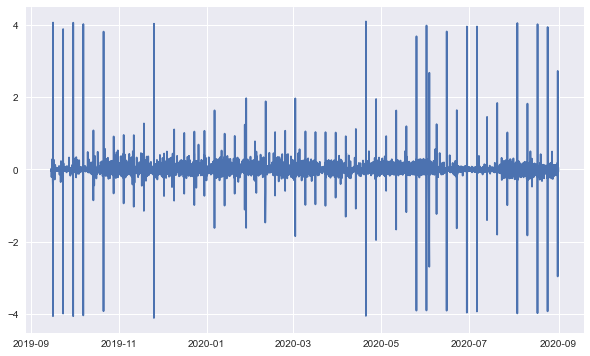

In [75]:
logdiffshifting = Preprocessed_data_logscale-Preprocessed_data_logscale.shift()
plt.plot(logdiffshifting)
plt.show()

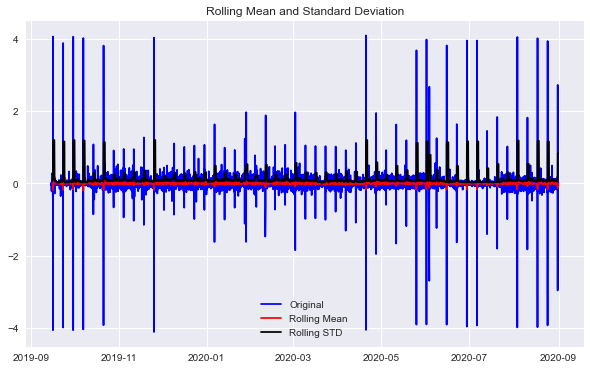

Results of Dickey Fuller Test:
Test Statistics           -1.810791e+01
p-value                    2.542429e-30
#Lags Used                 3.700000e+01
No of Observations used    8.297000e+03
Critical Value (1%)       -3.431138e+00
Critical Value (5%)       -2.861888e+00
Critical Value (10%)      -2.566955e+00
dtype: float64


In [76]:
logdiffshifting.dropna(inplace=True)
test_stationary(logdiffshifting)

5.Seasional Decomposition

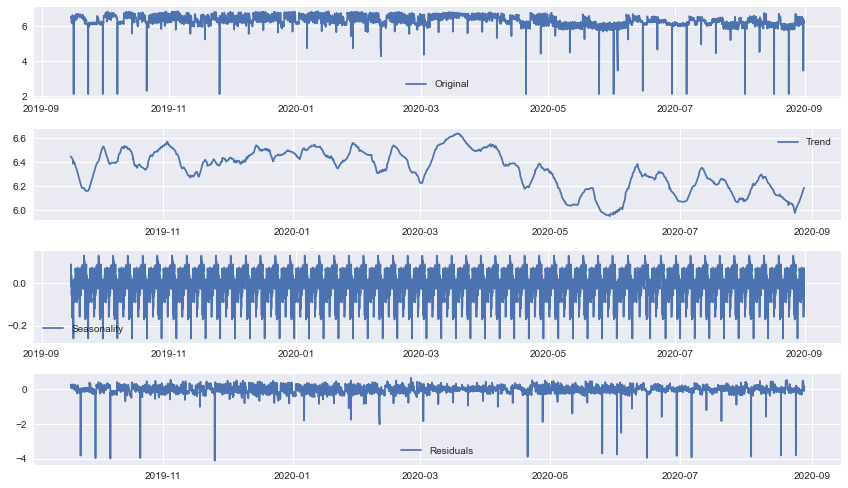

In [90]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(Preprocessed_data_logscale,period=168)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,7))
plt.subplot(411)
plt.plot(Preprocessed_data_logscale,label="Original")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend,label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal,label="Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual,label = "Residuals")
plt.legend(loc="best")
plt.tight_layout()



# ARIMA Model

In [91]:
from statsmodels.tsa.stattools import arma_order_select_ic
arma_order_select_ic(logdiffshifting)

{'bic':              0           1           2
 0  2609.826042   28.679210   37.664829
 1   781.967276   37.664021 -399.173282
 2   257.462600 -283.940694 -411.816327
 3   105.490914 -414.183785 -420.631690
 4    77.599723 -427.708325 -418.939825,
 'bic_min_order': (4, 1)}

In [93]:
from statsmodels.tsa.arima_model import ARIMA

#AR Model

Printing AR model


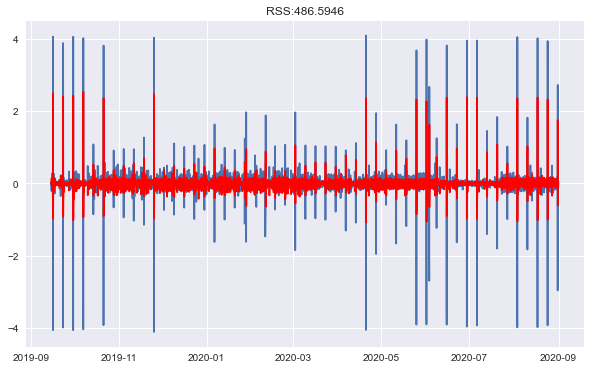

In [105]:
print("Printing AR model")
AR_mod= ARIMA (Preprocessed_data_logscale,order=(10,1,0))
result_AR=AR_mod.fit(disp=1)
plt.plot(logdiffshifting)
plt.plot(result_AR.fittedvalues,color="red")
plt.title("RSS:%.4f"%sum((result_AR.fittedvalues-logdiffshifting["KW"])**2))
plt.show()



#MA Model

Printing MA model


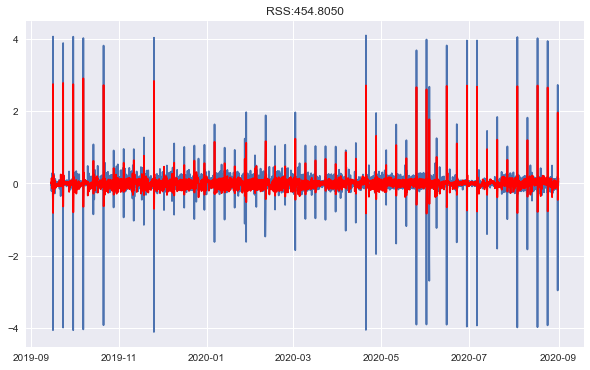

In [104]:
print("Printing MA model")
MA_mod= ARIMA (Preprocessed_data_logscale,order=(0,1,10))
result_MA=MA_mod.fit(disp=1)
plt.plot(logdiffshifting)
plt.plot(result_MA.fittedvalues,color="red")
plt.title("RSS:%.4f"%sum((result_MA.fittedvalues-logdiffshifting["KW"])**2))
plt.show()


#ARIMA Model

Printing ARIMA model


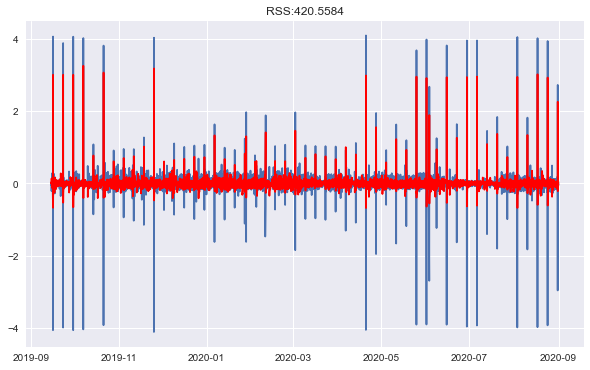

In [119]:
print("Printing ARIMA model")
ARIMA_mod= ARIMA(Preprocessed_data_logscale,order=(4,1,3))
result_ARIMA = ARIMA_mod.fit(disp=1, start_ar_lags=8)
plt.plot(logdiffshifting)
plt.plot(result_ARIMA.fittedvalues,color="red")
plt.title("RSS:%.4f"%sum((result_ARIMA.fittedvalues-logdiffshifting["KW"])**2))
plt.show()